# Titanic ML Competition

## Introduction

In this notebook we will be exploring the data for the Titanic machine learning competition from [Kaggle](https://www.kaggle.com/c/titanic/overview). The goals of the notebook are to:
* Better understand the data.
* See data relationships.
* Determine if there are patterns within the data.
* See what sorts of people were more likely to survive the disaster.

After this, we will create ML models to make predictions.

*Introduction from Kaggle*
```
The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).
```
<center>
    <img src='https://miro.medium.com/max/2000/1*fBkTkunRJ88FdEXEcGU_fg.jpeg' heigh=400 width=400>
</center>

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify

In [2]:
from math import pi

## Importing the dataset

In [3]:
titanic_df = pd.read_csv("Datasets/train.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


From the table above we can see the different data types that pandas assigned each column and that we have some columns with missing values. Before starting to work with these, we have to clean the data. 

In [5]:
titanic_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### Renaming of the columns & changing index

Here we change some of the names of the columns that doesn't sound that meaningful. (For instance SibSp or Parch). Also we make the index the passenger id, as it makes more sense there.

In [6]:
renamed_columns = {"Pclass":"Economic status","SibSp":"Number of siblings/spouses","Parch":"Number of parents/children"}
titanic_df.rename(columns=renamed_columns,inplace = True)

In [7]:
titanic_df.set_index(titanic_df["PassengerId"],inplace = True)
titanic_df.drop(columns="PassengerId",inplace=True)

### Data types

Now we will convert some columns to more appropriate data type, which will make things easier to work later. Additionally, this reduces the memory usage of the dataset.

The columns with object data type are candidates to be of categorical type. For this we check the cardinality they have.

In [8]:
titanic_df.select_dtypes(include=['object']).nunique()

Name        891
Sex           2
Ticket      681
Cabin       147
Embarked      3
dtype: int64

In [9]:
titanic_df["Sex"] = titanic_df["Sex"].astype("category")
titanic_df["Embarked"] = titanic_df["Embarked"].astype("category")

Other column that could be categorical is the one representing the economic status.

In [10]:
titanic_df["Economic status"] = titanic_df["Economic status"].astype("category")

Not always is about converting columns to categorical data types, we can also convert numerical types that use 64 bits to smaller sizes (such as 8 bits, 16, 32). By doing this we can reduce even further the memory usage of the dataset.

Before converting SibSp/Parch to a an integer of smaller size, we have to check the maximum number they have. *(Max int of int8:127(signed))*

In [11]:
titanic_df[["Number of siblings/spouses","Number of parents/children"]].max()

Number of siblings/spouses    8
Number of parents/children    6
dtype: int64

As there is no problem we can make the conversions.

In [12]:
titanic_df["Number of siblings/spouses"] = titanic_df["Number of siblings/spouses"].astype("int8")
titanic_df["Number of parents/children"] = titanic_df["Number of parents/children"].astype("int8")

In [13]:
titanic_df["Survived"] = titanic_df["Survived"].astype("int8")

### Missing values

This is one of the most important things to do in data analysis. It will be mainly develop on the different preprocessings to the data for the models. Now we are just going to fill the missing values from the `cabin` column with `-`.

In [14]:
titanic_df["Cabin"].fillna("-",inplace=True)

### Data conversions

Here we change some of the texts the data has, so that they are more meaningful.

In [15]:
new_economic_status_names = {1:"Upper",2:"Middle",3:"Lower"}
titanic_df["Economic status"].cat.rename_categories(new_economic_status_names,inplace=True)

In [16]:
new_port_names = {"C":"Cherbourg","Q":"Queenstown","S":"Southhampton"}
titanic_df["Embarked"].cat.rename_categories(new_port_names,inplace = True)

In [17]:
new_sex = {"male":"Male","female":"Female"}
titanic_df["Sex"].cat.rename_categories(new_sex,inplace = True)

### Reordering columns

Finally, we order the dataset in a more relevant way.

In [18]:
personal_info = ["Name","Sex","Age"]
economic_status = ["Economic status","Fare"]
family = ["Number of siblings/spouses","Number of parents/children"]
journey = ["Cabin","Embarked","Ticket","Survived"]
new_order = personal_info + economic_status + family + journey
titanic_df = titanic_df.reindex(columns = new_order)

### Dataset after handling it

In [19]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column                      Non-Null Count  Dtype   
---  ------                      --------------  -----   
 0   Name                        891 non-null    object  
 1   Sex                         891 non-null    category
 2   Age                         714 non-null    float64 
 3   Economic status             891 non-null    category
 4   Fare                        891 non-null    float64 
 5   Number of siblings/spouses  891 non-null    int8    
 6   Number of parents/children  891 non-null    int8    
 7   Cabin                       891 non-null    object  
 8   Embarked                    889 non-null    category
 9   Ticket                      891 non-null    object  
 10  Survived                    891 non-null    int8    
dtypes: category(3), float64(2), int8(3), object(3)
memory usage: 47.3+ KB


Here we can see that the memory usage was reduced by approximately ~35KB.

In [20]:
titanic_df.head()

,Name,Sex,Age,Economic status,Fare,Number of siblings/spouses,Number of parents/children,Cabin,Embarked,Ticket,Survived
PassengerId,,,,,,,,,,,
1,"Braund, Mr. Owen Harris",Male,22.0,Lower,7.2500,1,0,-,Southhampton,A/5 21171,0
2,"Cumings, Mrs. John Bradley (Florence Briggs Th...",Female,38.0,Upper,71.2833,1,0,C85,Cherbourg,PC 17599,1
3,"Heikkinen, Miss. Laina",Female,26.0,Lower,7.9250,0,0,-,Southhampton,STON/O2. 3101282,1
4,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",Female,35.0,Upper,53.1000,1,0,C123,Southhampton,113803,1
5,"Allen, Mr. William Henry",Male,35.0,Lower,8.0500,0,0,-,Southhampton,373450,0


## Exploratory Data Analysis

First, let's start by asking some simple questions that will get us closer to the question that matters. What sorts of people were more likely to survive?
* How many survived?
* How much does the sex determine the chances of survival?
* What about the age?
* Does the economic status helps to determine it?

### How many survived the disaster?

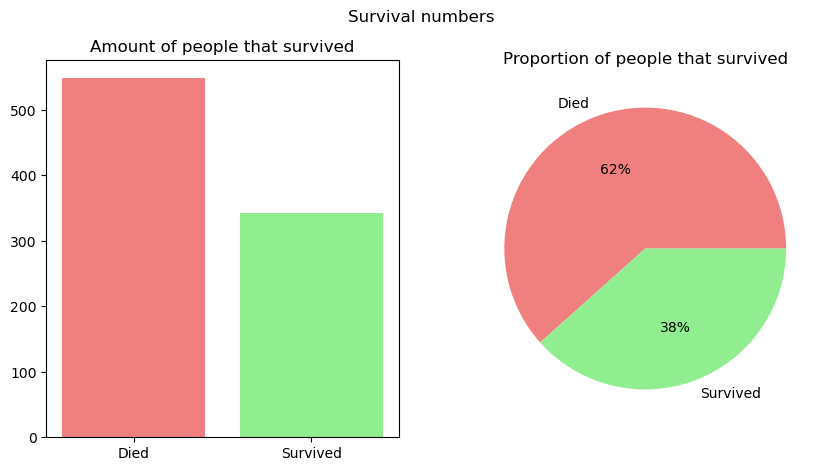

In [21]:
survival_values = titanic_df['Survived'].value_counts()
names = ['Died',"Survived"]
plt.figure(figsize=(10, 5), dpi=100)
 
plt.subplot2grid(shape=(1,2),loc=(0,0))
plt.bar(x=survival_values.index,height=survival_values.values,color=['lightcoral', 'lightgreen'])
plt.xticks(survival_values.index,names)
plt.title("Amount of people that survived")

plt.subplot2grid(shape=(1,2),loc=(0,1))
plt.pie(survival_values, labels=names,colors=['lightcoral', 'lightgreen'], autopct='%1.0f%%')
plt.title("Proportion of people that survived")

plt.suptitle('Survival numbers')
plt.show()

We can see that approximately 40% of the passengers survived.

### How much does the sex affect the chances of survival?

Let's begin by seeing the proportions of the passengers.

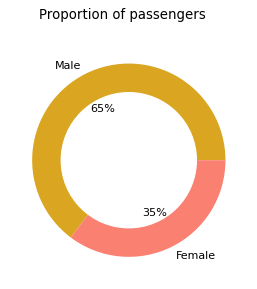

In [22]:
sex_proportions = titanic_df["Sex"].value_counts()
circle=plt.Circle( (0,0), 0.7, color='white')
plt.figure(dpi=80)
plt.pie(sex_proportions.values, labels=sex_proportions.index, colors=['goldenrod','salmon'],autopct='%1.0f%%')
p=plt.gcf()
p.gca().add_artist(circle)
plt.suptitle('Proportion of passengers')
plt.show()

Now let's see the survival rate.

In [23]:
survival_by_sex = titanic_df.groupby(by="Sex")["Survived"].agg("mean")
survival_by_sex

Sex
Female    0.742038
Male      0.188908
Name: Survived, dtype: float64

Text(0.5, 1.0, 'Proportions of people that survived by sex')

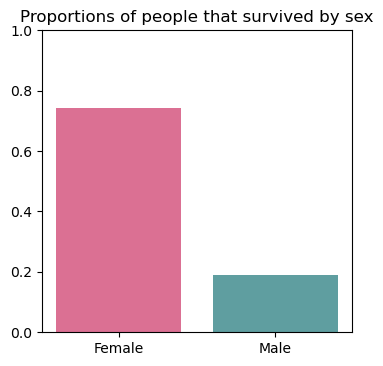

In [24]:
plt.figure(figsize=(4, 4), dpi=100)
plt.bar(x=survival_by_sex.index,height=survival_by_sex.values,color=['palevioletred', 'cadetblue'])
plt.ylim(top=1)
plt.title("Proportions of people that survived by sex")

We can clearly see that women proportionally had a greater survival rate than men.

### What about the age?

Can we see a pattern by exploring the age? Let's try to see if the children were more likely to survive.

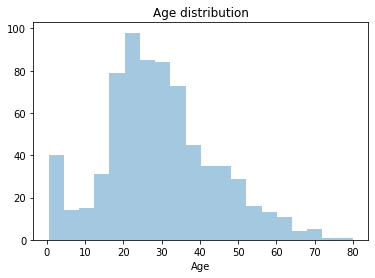

In [25]:
sns.distplot( a=titanic_df["Age"], hist=True, kde=False, rug=False )
plt.title("Age distribution")
plt.show()

We can see that the main group of people that was on the ship were adults, followed by children and then by old people.

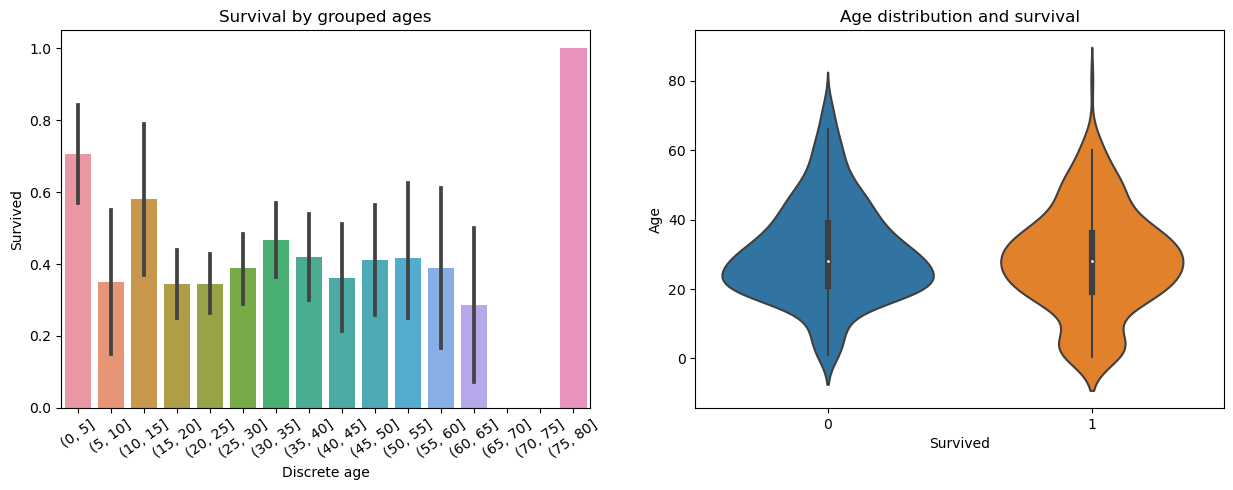

In [77]:
plt.figure(figsize=(15, 5), dpi=100)
titanic_df["Discrete age"] = pd.cut(titanic_df["Age"],bins=range(0,85,5))
plt.subplot2grid(shape=(1,2),loc=(0,0))
g = sns.barplot('Discrete age','Survived', data=titanic_df)
g.tick_params('x',labelrotation=35)
plt.title("Survival by grouped ages")
    
plt.subplot2grid(shape=(1,2),loc=(0,1))
sns.violinplot(x=titanic_df["Survived"], y=titanic_df["Age"])
plt.title("Age distribution and survival")
 
plt.show()

Here we can see that children were more likely to survive in both graphs.

In [27]:
children = titanic_df["Age"] < 13
survived = titanic_df["Survived"] == 1
survived_age = titanic_df.loc[survived & children,"Age"]
died_age = titanic_df.loc[(~survived) & children,"Age"]

In [28]:
survived_age.count()

40

In [29]:
died_age.count()

29

### Does the economic status helps to determine it?

In [30]:
total_class_members = titanic_df["Economic status"].value_counts(normalize=True).round(2)

In [31]:
survival_by_status = titanic_df.groupby(by="Economic status")["Survived"].value_counts(normalize=True).round(2)
survival_by_status = survival_by_status.unstack().reset_index()
survival_by_status.index = survival_by_status["Economic status"]
survival_by_status = survival_by_status.drop(columns="Economic status")

In [32]:
renamed_columns = {0:"Died",1:"Survived"}
survival_by_status = survival_by_status.rename(columns=renamed_columns)
survival_by_status.columns.name = None
survival_by_status

,Died,Survived
Economic status,,
Upper,0.37,0.63
Middle,0.53,0.47
Lower,0.76,0.24


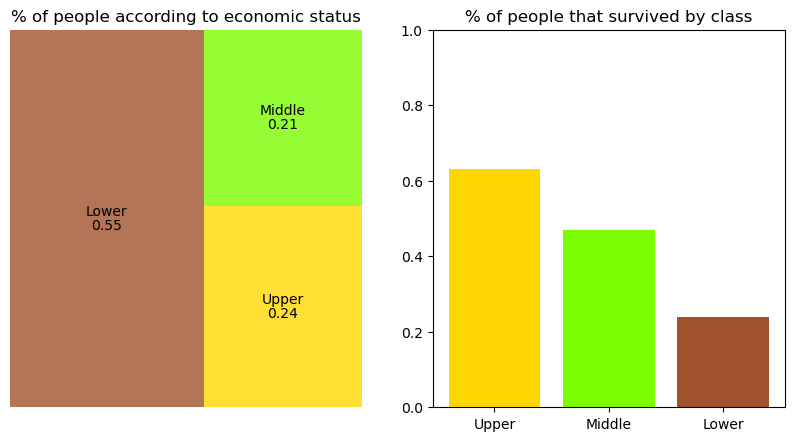

In [33]:
plt.figure(figsize=(10, 5), dpi=100)
 
plt.subplot2grid(shape=(1,2),loc=(0,0))
squarify.plot(sizes=total_class_members,value=total_class_members, label=total_class_members.index, alpha=.8,color=['sienna', 'gold','lawngreen'])
plt.axis('off')  
plt.title("% of people according to economic status")   
    
plt.subplot2grid(shape=(1,2),loc=(0,1))
plt.bar(x=survival_by_status.index,height=survival_by_status["Survived"].values,color=['gold', 'lawngreen','sienna'])
plt.ylim(top=1)
plt.title("% of people that survived by class")

plt.show()

On the graphs we can see that people from lower class were more likely to die than from upper class.

### What happened to the families?

Here we will see if people with families had more chances of survival.

The dataset includes 2 attributes which count the number of members of each group.
* Number of siblings/spouses (sibsp):
    * Sibling = brother, sister, stepbrother, stepsister
    * Spouse = husband, wife (mistresses and fiancés were ignored)

* Number of parents/children (parch):
    * Parent = mother, father
    * Child = daughter, son, stepdaughter, stepson
    
*Note: Some children travelled only with a nanny, therefore parch=0 for them.*

In [34]:
titanic_df["Number of siblings/spouses"].value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: Number of siblings/spouses, dtype: int64

In [35]:
titanic_df["Number of parents/children"].value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Number of parents/children, dtype: int64

We can see that the majority of the passengers traveled alone.

In [36]:
new_name = {"Number of siblings/spouses":"Total"}
sibsp = titanic_df.groupby(by="Number of siblings/spouses")["Survived"].value_counts(normalize=True).to_frame().unstack()
sibsp = sibsp.fillna(0)
sibsp.columns = sibsp.columns.get_level_values(1)
sibsp.columns.name = None
sibsp = sibsp.rename(columns={0:"Died",1:"Survived"}) 
sibsp

,Died,Survived
Number of siblings/spouses,,
0,0.654605,0.345395
1,0.464115,0.535885
2,0.535714,0.464286
3,0.750000,0.250000
4,0.833333,0.166667
5,1.000000,0.000000
8,1.000000,0.000000


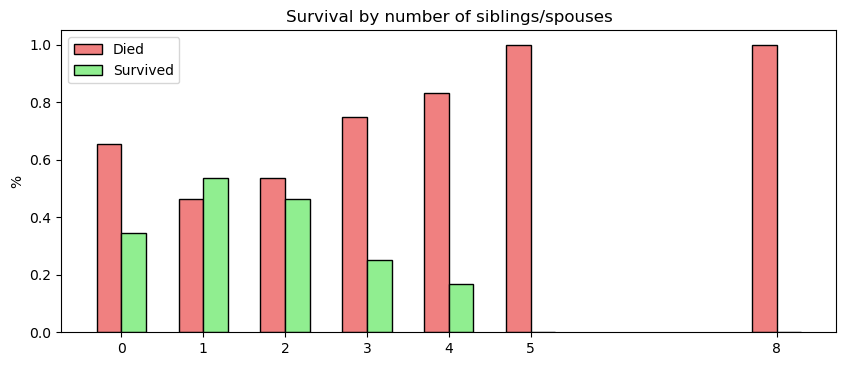

In [37]:
bar_width = 0.3
start_first_bar = sibsp.index-bar_width/2
start_second_bar = sibsp.index+bar_width/2

plt.figure(figsize=(10, 4), dpi=100)
plt.bar(start_first_bar, sibsp["Died"], width = bar_width, color = 'lightcoral', edgecolor = 'black', label='Died')
plt.bar(start_second_bar, sibsp["Survived"], width = bar_width, color = 'lightgreen', edgecolor = 'black',  label='Survived')
plt.xticks(sibsp.index)
plt.ylabel('%')
plt.legend()
plt.title("Survival by number of siblings/spouses")
plt.show()

In the graph we can see that those with one or two siblings/spouses seem more likely to survive. Let's see now with the parents and children.

In [38]:
new_name = {"Number of parents/children":"Total"}
parch = titanic_df.groupby(by="Number of parents/children")["Survived"].value_counts(normalize=True).to_frame().unstack()
parch = parch.fillna(0)
parch.columns = parch.columns.get_level_values(1)
parch.columns.name = None
parch = parch.rename(columns={0:"Died",1:"Survived"}) 
parch

,Died,Survived
Number of parents/children,,
0,0.656342,0.343658
1,0.449153,0.550847
2,0.500000,0.500000
3,0.400000,0.600000
4,1.000000,0.000000
5,0.800000,0.200000
6,1.000000,0.000000


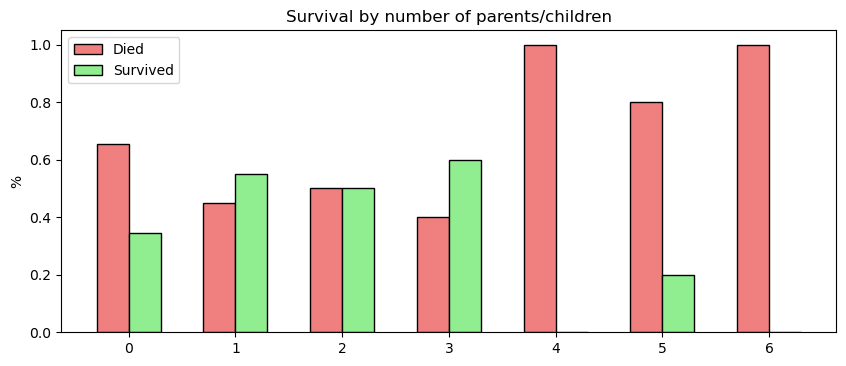

In [39]:
bar_width = 0.3
start_first_bar = parch.index-bar_width/2
start_second_bar = parch.index+bar_width/2

plt.figure(figsize=(10, 4), dpi=100)
plt.bar(start_first_bar, parch["Died"], width = bar_width, color = 'lightcoral', edgecolor = 'black', label='Died')
plt.bar(start_second_bar, parch["Survived"], width = bar_width, color = 'lightgreen', edgecolor = 'black',  label='Survived')
plt.xticks(parch.index)
plt.ylabel('%')
plt.legend()
plt.title("Survival by number of parents/children")
plt.show()

In this case we can see again that those with a family were more likely to survive than those that wet alone.

### Is there any relationship with the embarkation port?

In this section we will see if people that embarked in a certain port survived more than from the others.

In [40]:
embark_ports = titanic_df["Embarked"].value_counts(normalize=True).round(2)

In [41]:
survival_by_ports = titanic_df.groupby(by="Embarked")["Survived"].agg("mean")

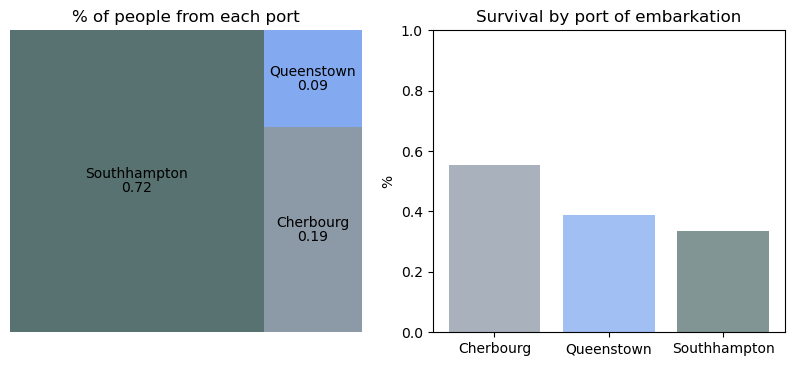

In [42]:
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot2grid(shape=(1,2),loc=(0,0))
squarify.plot(sizes=embark_ports,value=embark_ports, label=embark_ports.index, alpha=.8,color=['darkslategrey', 'slategrey','cornflowerblue'])
plt.axis('off')  
plt.title("% of people from each port")   

plt.subplot2grid(shape=(1,2),loc=(0,1))
plt.bar(survival_by_ports.index, survival_by_ports.values, color = ['slategrey', 'cornflowerblue','darkslategrey'], alpha = 0.6)
plt.ylim(top=1)
plt.ylabel('%')
plt.title("Survival by port of embarkation")
plt.show()

We can see that those that embarked in Cherbourg had slightly better chances, though we have to take into account that Southhampton was the port from which most of the people embarked.

### Is there any relationship between age/fare and the survival?

Now that we have seen each individual variable in its own, let's start to look for correlations between them.

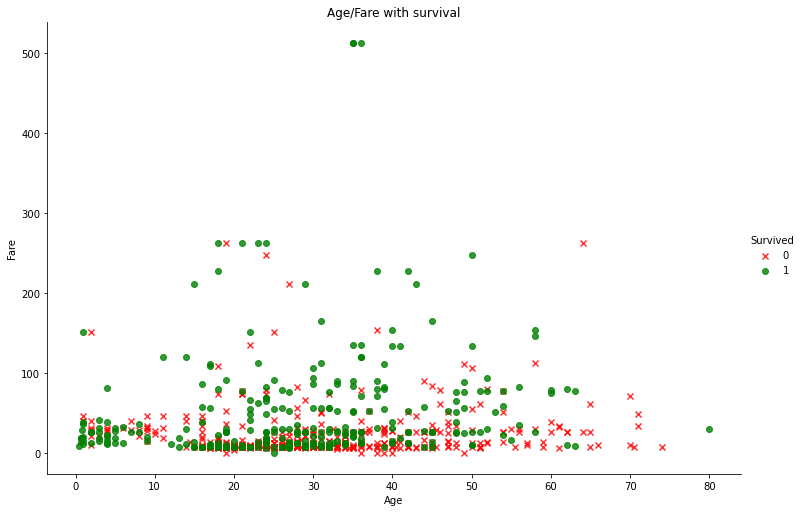

In [43]:
sns.lmplot( x='Age', y='Fare',data=titanic_df,fit_reg=False, hue='Survived', legend=True,height=7,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Age/Fare with survival")
plt.show()

In this graph we can clearly see that those that paid a higher fare likely survived. Let's see if we can get a better view by making a graph for each sex.

In [44]:
columns = ["Age","Fare","Survived"]
is_male = titanic_df["Sex"] == "Male"
fare_limit = titanic_df["Fare"] < 300 # So that we can see better the lower values
age_fare_male = titanic_df.loc[is_male & fare_limit,columns]
age_fare_female = titanic_df.loc[(~is_male) & fare_limit,columns]

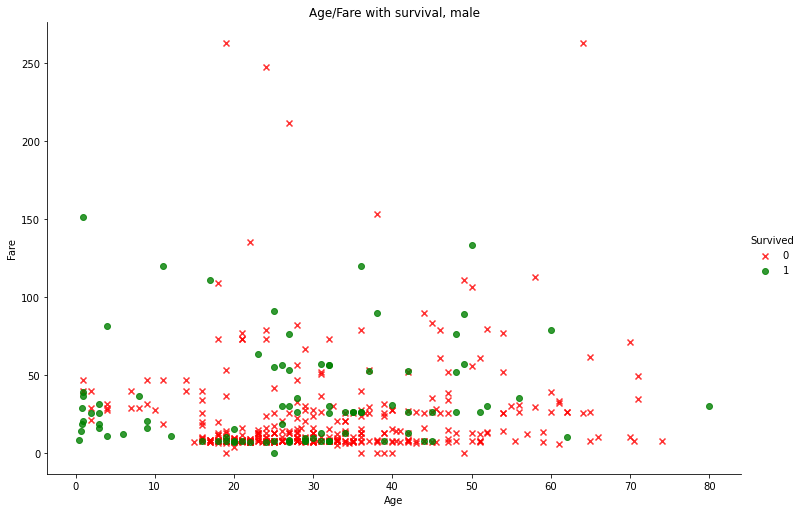

In [45]:
sns.lmplot( x='Age', y='Fare',data=age_fare_male,fit_reg=False, hue='Survived', legend=True,height=7,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Age/Fare with survival, male")
plt.show()

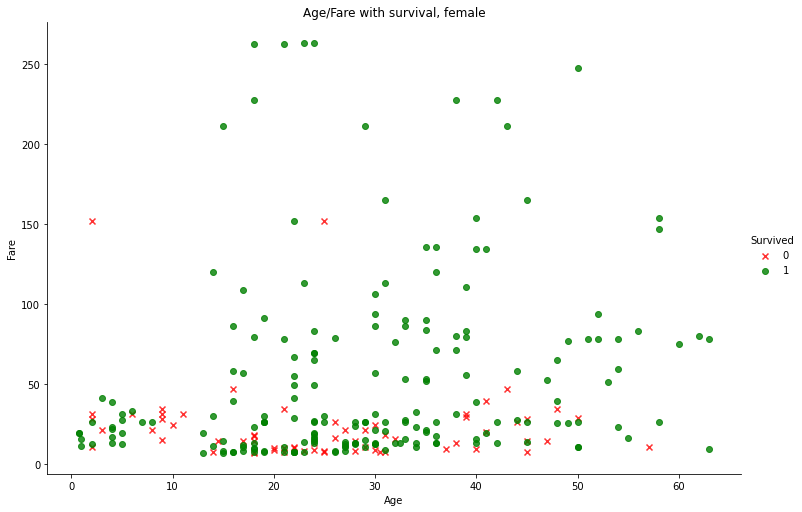

In [46]:
sns.lmplot( x='Age', y='Fare',data=age_fare_female,fit_reg=False, hue='Survived', legend=True,height=7,aspect=1.5,markers=["x","o"],palette=['red','green'])
plt.title("Age/Fare with survival, female")
plt.show()

This graph further confirms what we saw before, women more likely survived. In addition, we can see that also with the children.

Let's try to draw the boundaries of the socio-economic status by looking at different numerical values.

In [47]:
titanic_df.groupby(by="Economic status")["Fare"].agg(["min","mean","max","std"]).round(2)

,min,mean,max,std
Economic status,,,,
Upper,0.0,84.15,512.33,78.38
Middle,0.0,20.66,73.50,13.42
Lower,0.0,13.68,69.55,11.78


Seeing that the minimum fare was 0 for all economic status, I decided to take a look at these particular cases. 

In [48]:
titanic_df.loc[titanic_df["Fare"] == 0]

,Name,Sex,Age,Economic status,Fare,Number of siblings/spouses,Number of parents/children,Cabin,Embarked,Ticket,Survived
PassengerId,,,,,,,,,,,
180,"Leonard, Mr. Lionel",Male,36.0,Lower,0.0,0,0,-,Southhampton,LINE,0
264,"Harrison, Mr. William",Male,40.0,Upper,0.0,0,0,B94,Southhampton,112059,0
272,"Tornquist, Mr. William Henry",Male,25.0,Lower,0.0,0,0,-,Southhampton,LINE,1
278,"Parkes, Mr. Francis ""Frank""",Male,NaN,Middle,0.0,0,0,-,Southhampton,239853,0
303,"Johnson, Mr. William Cahoone Jr",Male,19.0,Lower,0.0,0,0,-,Southhampton,LINE,0
414,"Cunningham, Mr. Alfred Fleming",Male,NaN,Middle,0.0,0,0,-,Southhampton,239853,0
467,"Campbell, Mr. William",Male,NaN,Middle,0.0,0,0,-,Southhampton,239853,0
482,"Frost, Mr. Anthony Wood ""Archie""",Male,NaN,Middle,0.0,0,0,-,Southhampton,239854,0
598,"Johnson, Mr. Alfred",Male,49.0,Lower,0.0,0,0,-,Southhampton,LINE,0


By investigating a little, it turned out that these people boarded the ship without paying a fare for different reasons. For example, Andrews, Mr. Thomas Jr. was the naval architect for the ship, while other passengers were part of the ["guarantee group"](https://www.encyclopedia-titanica.org/titanic-guarantee-group/).


Let's continue without taking into account these cases.

In [49]:
passengers_with_fare = titanic_df.loc[titanic_df["Fare"]>0]
fare_range_by_status = passengers_with_fare.groupby(by="Economic status")["Fare"].agg(["min","mean","max","std"]).round(2)
fare_range_by_status

,min,mean,max,std
Economic status,,,,
Upper,5.00,86.15,512.33,78.21
Middle,10.50,21.36,73.50,13.08
Lower,4.01,13.79,69.55,11.76


By taking into account the mean and standard deviation, we can see that some groups overlap between each other in parts, thus blurring the boundaries. Of course here we have to take into account that the fare in this case includes all of the fares from one family.

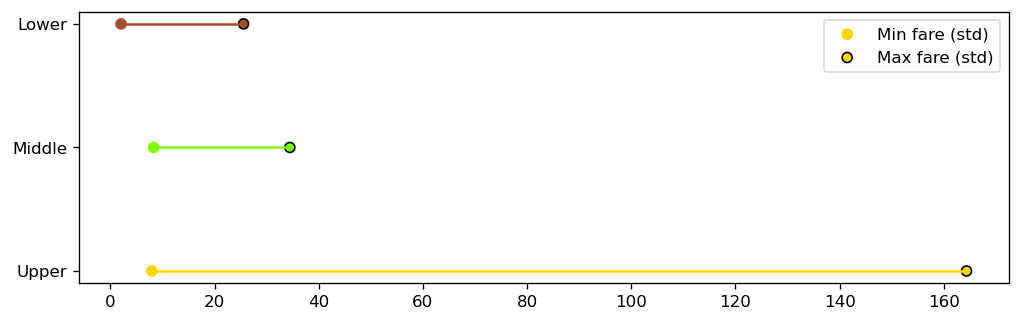

In [50]:
min_fare_std = fare_range_by_status["mean"] - fare_range_by_status["std"]
max_fare_std = fare_range_by_status["mean"] + fare_range_by_status["std"]
colors = ['gold','lawngreen','sienna']
plt.figure(figsize=(10, 3), dpi=120)
plt.hlines(y=fare_range_by_status.index, xmin=min_fare_std, xmax=max_fare_std, color=colors, alpha=1)
plt.scatter(min_fare_std, fare_range_by_status.index, color=colors, alpha=1, label='Min fare (std)')
plt.scatter(max_fare_std, fare_range_by_status.index, color=colors, alpha=1 , linewidths=1,edgecolor="black",label='Max fare (std)')
plt.legend()
 
plt.show()

### How is the survival distributed by dividing sex and the socio-economic status?

In [51]:
female = titanic_df["Sex"] == "Female"
female_passengers = titanic_df.loc[female]
survival_female_class = female_passengers.groupby(by="Economic status")["Survived"].value_counts(normalize=True).round(2).unstack()
survival_female_class = survival_female_class.rename(columns={0:"Died",1:"Survived"})
survival_female_class.columns.name = None
survival_female_class

,Died,Survived
Economic status,,
Upper,0.03,0.97
Middle,0.08,0.92
Lower,0.50,0.50


In [52]:
male_passengers = titanic_df.loc[~female]
survival_male_class = male_passengers.groupby(by="Economic status")["Survived"].value_counts(normalize=True).round(2).unstack()
survival_male_class = survival_male_class.rename(columns={0:"Died",1:"Survived"})
survival_male_class.columns.name = None
survival_male_class

,Died,Survived
Economic status,,
Upper,0.63,0.37
Middle,0.84,0.16
Lower,0.86,0.14


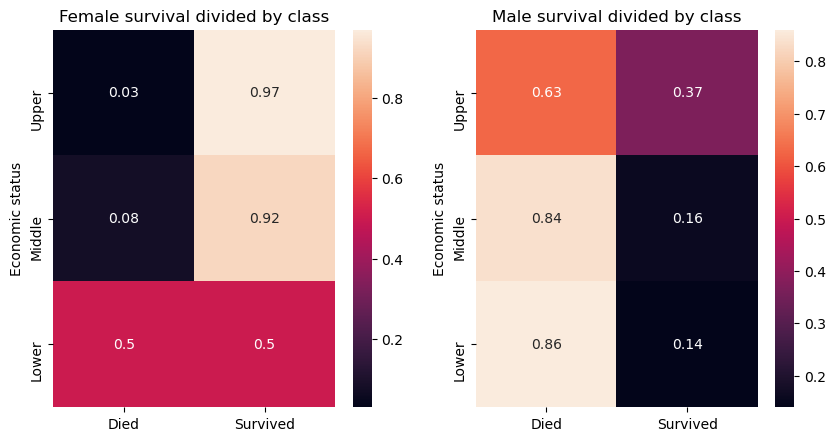

In [80]:
plt.figure(figsize=(10, 5), dpi=100)
 
plt.subplot2grid(shape=(1,2),loc=(0,0))
h1 = sns.heatmap(survival_female_class,annot=True)
plt.title("Female survival divided by class")
    
plt.subplot2grid(shape=(1,2),loc=(0,1))
h2 = sns.heatmap(survival_male_class,annot=True)
plt.title("Male survival divided by class")

plt.show()

Here we can clearly see that women from the middle and upper status have way higher chances of survival, while for those of lower class the chances drop by around 40%.

Regarding the men, we can see that those from upper class have slightly better chances than those in middle and lower classes.

### Expansion on the families

Let's try to see if we can get anything new by joining the number of siblings/spouses and parents/children.

In [54]:
titanic_df["Family size"] = titanic_df["Number of parents/children"] + titanic_df["Number of siblings/spouses"] + 1 # To count the passenger

In [56]:
family_size = titanic_df["Family size"].value_counts(normalize=True).round(2)

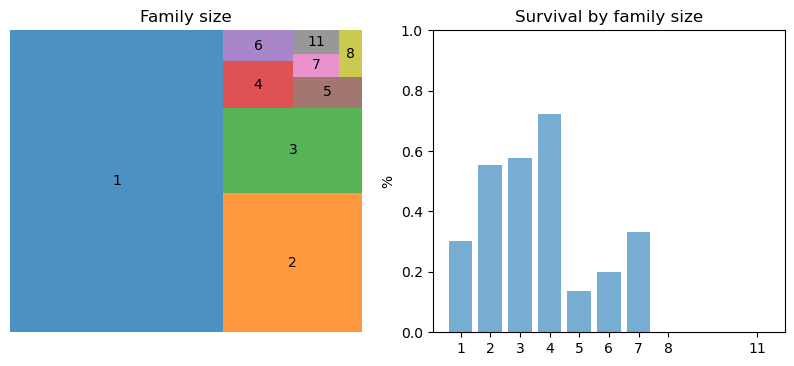

In [64]:
colors=["tab:blue","tab:orange","tab:green","tab:red","tab:purple","tab:brown","tab:pink","tab:gray","tab:olive"]
plt.figure(figsize=(10, 4), dpi=100)
plt.subplot2grid(shape=(1,2),loc=(0,0))
squarify.plot(sizes=family_size,label=family_size.index,color=colors, alpha=.8)
plt.axis('off')  
plt.title("Family size")   

plt.subplot2grid(shape=(1,2),loc=(0,1))
plt.bar(family_size.index, titanic_df.groupby(by="Family size")["Survived"].agg("mean"), alpha = 0.6)
plt.ylim(top=1)
plt.xticks(ticks=family_size.index)
plt.ylabel('%')
plt.title("Survival by family size")
plt.show()

Here we can see more clearly that families that have 2 to 4 members have higher survival chances than bigger families or passengers alone.


 Sex          Female  Male
Family size              
1               126   411
2                87    74
3                49    53
4                19    10
5                12     3
6                 8    14
7                 8     4
8                 2     4
11                3     4


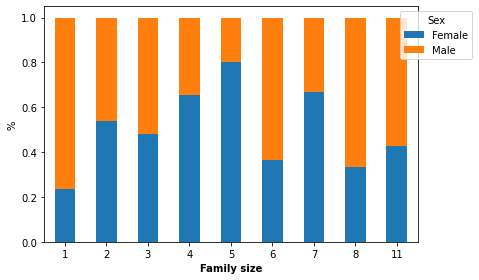

In [81]:
table = pd.crosstab(titanic_df['Family size'], titanic_df['Sex'])
print('\n', table)
table_fractions = table.div(table.sum(1).astype(float), axis=0)
g = table_fractions.plot(kind="bar", stacked=True)
plt.xticks(rotation=0)
plt.xlabel('Family size', weight='bold')
plt.ylabel('%')
plt.tight_layout()
leg = plt.legend(title='Sex', loc=9, bbox_to_anchor=(1.05, 1.0))

Here we can see that the proportion of males is greatest for family size 1 (males traveling alone), and drops for family size of 2, 3, and 4 members (more females). This can explain the survival chances of those groups.

## Conclusions
    
* Women are more likely to have survived.
* Many of the children survived.
* Families (2 to 4 members) have better chances of survival.
* There are clear relationships between sex, gender, and socio-economic status.

## References


* [A Tour of Machine Learning in Python](https://rpmarchildon.com/ai-titanic/)
* [Encyclopedia-titanica](https://www.encyclopedia-titanica.org/).